In [ ]:
import tensorflow as tf

In [ ]:
text_file=tf.keras.utils.get_file(fname="fra-eng.zip",origin="https://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",extract=True)

3423204/3423204 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import pathlib

In [ ]:
text_file1=pathlib.Path(text_file)/"fra.txt"

In [ ]:
print(text_file)

/root/.keras/datasets/fra-eng_extracted


In [ ]:
with open(text_file1) as fp:
    text_pair=[line for line in fp]

In [ ]:
import random
for _ in range(5):
    print(random.choice(text_pair))

A man cannot be judged by his appearance.	On ne juge pas un homme sur son apparence.

They can't push us around.	Elles ne peuvent pas nous intimider.

Maybe I should just quit.	Peut-être que je devrais simplement démissionner.

She speaks English as if she were a native speaker.	Elle parle anglais comme si c'était sa langue maternelle.

How is that different?	En quoi est-ce différent ?



In [ ]:
import unicodedata
import re

def normalize(line):
    line = unicodedata.normalize("NFKC", line.strip())
    line = line.lower()
    line = re.sub(r"([^\w])(?=\S)", r"\1 ", line)
    line = re.sub(r"(\S)([^\w])", r"\1 \2", line)
    line = re.sub(r"(\S[^\w])$", r"\1 ", line)
    line = re.sub(r"(\S)([^\w])(?!\s)", r"\1 \2", line)

    eng, fre = line.split("\t")
    fre = "[start] " + fre + " [end]"
    return eng, fre


In [ ]:
with open(text_file1) as fp:
    text_pair=[normalize(line) for line in fp]

In [ ]:
import random
for _ in range(5):
    print(random.choice(text_pair))

('i   feel   giddy  .', "[start]  j  '  ai   la   tête   qui   tourne  . [end]")
("that  '  s   a   really   shallow   thing   to   say  .", '[start]  ça   manque   vraiment   de   profondeur  . [end]')
('yesterday   we   painted   the   town   red  .', '[start]  hier  ,  on   a   fait   la   bringue  . [end]')
("i   can  '  t   forgive   any   of   you  .", '[start]  je   ne   peux   pardonner   aucun   de   vous  . [end]')
("you  '  re   under   arrest   for   endangering   the   welfare   of   a   minor  .", "[start]  vous   êtes   en   état   d  '  arrestation   pour   mise   en   danger   du   bien  -  être   d  '  un   mineur  . [end]")


In [ ]:
eng_tokens,fre_tokens=set(),set()
eng_maxlen,fre_max_len=0,0
for eng,fre in text_pair:
   eng_token,fre_token=eng.split(),fre.split()
   eng_maxlen=max(eng_maxlen,len(eng.split()))
   fre_max_len=max(fre_max_len,len(fre.split()))
   eng_tokens.update(eng_token)
   fre_tokens.update(fre_token)
print(len(eng_tokens))
print(len(fre_tokens))
print(eng_maxlen)
print(fre_max_len)


13968
23892
54
70


In [ ]:
import pickle
with open("text_pair.pickle","wb") as fp:
    pickle.dump(text_pair,fp)

In [ ]:
from tensorflow.keras.layers import TextVectorization
import pickle
with open("text_pair.pickle","rb")as fp:
  text_pair=pickle.load(fp)


In [ ]:
random.shuffle(text_pair)

In [ ]:
n_val=int(.15*len(text_pair))
n_train=len(text_pair)-2*n_val
train_pair=text_pair[:n_train]
test_pair=text_pair[n_train:n_train+n_val]


In [ ]:
vocab_en=10000
vocab_fr=20000
seq_len=25


In [ ]:
eng_vect=TextVectorization(
    max_tokens=vocab_en,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_len
    )

In [ ]:
fre_vect=TextVectorization(
    max_tokens=vocab_fr,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_len
    )

In [ ]:
train_eng=[pair[0] for pair in train_pair]
train_fre=[pair[1] for pair in train_pair]

In [ ]:
eng_vect.adapt(train_eng)
fre_vect.adapt(train_fre)


In [ ]:
with open('vectorizer.pickle','wb') as fp:
    data={"train":train_pair,"test":test_pair,"eng_vect":eng_vect,"fre_vect":fre_vect,"eng_weights":eng_vect.get_weights(),"fre_weights":fre_vect.get_weights()}

    pickle.dump(data,fp)

In [ ]:
with open("vectorizer.pickle","rb") as fp:
    data=pickle.load(fp)

In [ ]:
train_pair=data["train"]
test_pair=data["test"]
eng_vect_config = data["eng_vect"].get_config()
eng_vect_weights = data["eng_weights"]
fre_vect_config = data["fre_vect"].get_config()
fre_vect_weights = data["fre_weights"]

eng_vect=TextVectorization.from_config(eng_vect_config)
eng_vect.set_weights(eng_vect_weights)
fre_vect=TextVectorization.from_config(fre_vect_config)
fre_vect.set_weights(fre_vect_weights)

In [ ]:
def format_dataset(eng,fre):
  # Ensure vectorizers are built within the dataset's graph
  # by applying them to a dummy input.
  _ = eng_vect(tf.constant([""]))
  _ = fre_vect(tf.constant([""]))

  eng=eng_vect(eng)
  fre=fre_vect(fre)

  source={'enc_inp':eng,
          "dec_inp":fre[:,:-1]}
  target=fre[:,1:]
  return (source,target)

def make_dataset(pairs,batch_size=64):
  eng_texts,fre_texts=zip(*pairs)
  eng_texts=list(eng_texts)
  fre_texts=list(fre_texts)
  dataset=tf.data.Dataset.from_tensor_slices((eng_texts,fre_texts))
  return dataset.batch(batch_size).map(format_dataset).shuffle(2048).prefetch(16).cache()

In [ ]:
eng_texts_train, fre_texts_train = zip(*train_pair)
eng_texts_test, fre_texts_test = zip(*test_pair)

eng_vect.adapt(list(eng_texts_train))
fre_vect.adapt(list(fre_texts_train))

train_ds=make_dataset(train_pair)
test_ds=make_dataset(test_pair)

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
def pos_enc_matrix(L,d,n=10000):
  assert d%2==0
  d2=d/2
  p=np.zeros((L,d))
  k=np.arange(L).reshape(-1,1)
  i=np.arange(d2).reshape(1,-1)

  denom=np.power(n,-i/d2)
  args=k*denom
  p[:,::2]=np.sin(args)
  p[:,1::2]=np.cos(args)
  return p

In [ ]:
import numpy as np
import tensorflow as tf

# Keep the original pos_enc_matrix as a reference
def pos_enc_matrix(L,d,n=10000):
  assert d%2==0
  d2=d/2
  p=np.zeros((L,d))
  k=np.arange(L).reshape(-1,1)
  i=np.arange(d2).reshape(1,-1)

  denom=np.power(n,-i/d2)
  args=k*denom
  p[:,::2]=np.sin(args)
  p[:,1::2]=np.cos(args)
  return p

class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
    super().__init__(**kwargs)
    self.seq_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim
    self.token_embeddings = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero=True)

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    input_seq_length = tf.shape(embedded_tokens)[1]

    position = tf.cast(tf.range(input_seq_length), dtype=tf.float32)[:, tf.newaxis]
    div_term = tf.exp(tf.range(0, self.embed_dim, 2, dtype=tf.float32) * - (tf.math.log(10000.0) / self.embed_dim))

    # Generate positional embeddings using TensorFlow operations
    pe_even = tf.sin(position * div_term)
    pe_odd = tf.cos(position * div_term)

    # Interleave the even and odd dimensions
    pe = tf.reshape(tf.stack([pe_even, pe_odd], axis=-1), (input_seq_length, self.embed_dim))

    # Expand dimensions to match embedded_tokens for broadcasting
    pe = tf.expand_dims(pe, axis=0)

    return embedded_tokens + pe

  def compute_mask(self, *args, **kwargs):
    return self.token_embeddings.compute_mask(*args, **kwargs)

  def get_config(self):
    config = super().get_config()
    config.update({"seq_length": self.seq_length, "vocab_size": self.vocab_size, "embed_dim": self.embed_dim})
    return config

In [ ]:
vocab_en=10000
vocab_fr=20000
seq_len=25


In [ ]:
for inputs,targets in train_ds.take(1):
  print(inputs["enc_inp"])
  embed_en=PositionalEmbedding(seq_len,vocab_en,512)
  en_emb=embed_en(inputs["enc_inp"])
  print(en_emb._keras_mask)

tf.Tensor(
[[ 15  11 100 ...   0   0   0]
 [137 604 384 ...   0   0   0]
 [ 12  54  81 ...   0   0   0]
 ...
 [ 25  30   3 ...   0   0   0]
 [ 15 351 440 ...   0   0   0]
 [ 15 662 206 ...   0   0   0]], shape=(64, 25), dtype=int64)
tf.Tensor(
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]], shape=(64, 25), dtype=bool)


In [ ]:
def self_attention(input_shape,prefix='att',mask=False,**kwargs):
  inputs=tf.keras.layers.Input(shape=input_shape,dtype="float32",name=prefix+'_in1')
  attention=tf.keras.layers.MultiHeadAttention(name=prefix+'_att1',**kwargs)
  norm=tf.keras.layers.LayerNormalization(name=prefix+'_norm1')
  add=tf.keras.layers.Add(name=prefix+'_add1')

  attout=attention(query=inputs,value=inputs,key=inputs,use_causal_mask=mask)
  output=norm(add([inputs,attout]))
  model=tf.keras.Model(inputs=inputs,outputs=output,name=f"{prefix}_att")
  return model

In [ ]:
seq_length=25
key_dim=128
num_heads=8

model=self_attention(input_shape=(seq_length,key_dim),num_heads=num_heads,key_dim=key_dim)

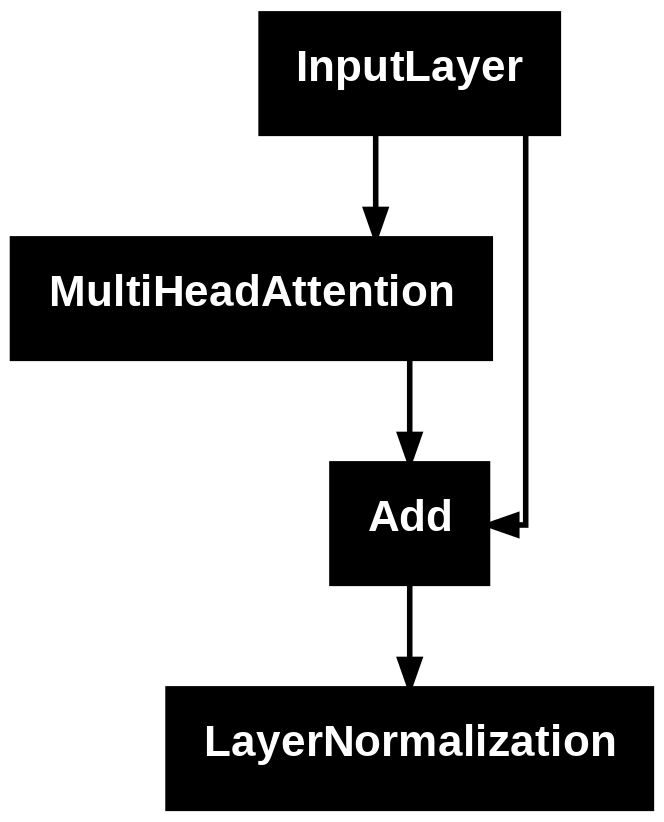

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
def cross_attention(input_shape,context_shape,prfix='att',**kwargs):
  context=tf.keras.layers.Input(shape=context_shape,dtype='float32',name=f"{prfix}_ctx2")
  inputs=tf.keras.layers.Input(shape=input_shape,dtype="float32",name=f"{prfix}_in2")
  attention=tf.keras.layers.MultiHeadAttention(name=f"{prfix}_att2",**kwargs)
  norm=tf.keras.layers.LayerNormalization(name=f"{prfix}_norm2")
  add=tf.keras.layers.Add(name=f"{prfix}_add2")

  attout=attention(query=inputs,value=context,key=context)
  output=norm(add([inputs,attout]))
  model = tf.keras.Model(inputs=[context, inputs], outputs=output, name=f"{prfix}_crsatt")
  return model

In [ ]:
model=cross_attention(input_shape=(seq_length,key_dim),context_shape=(seq_length,key_dim),num_heads=num_heads,key_dim=key_dim)

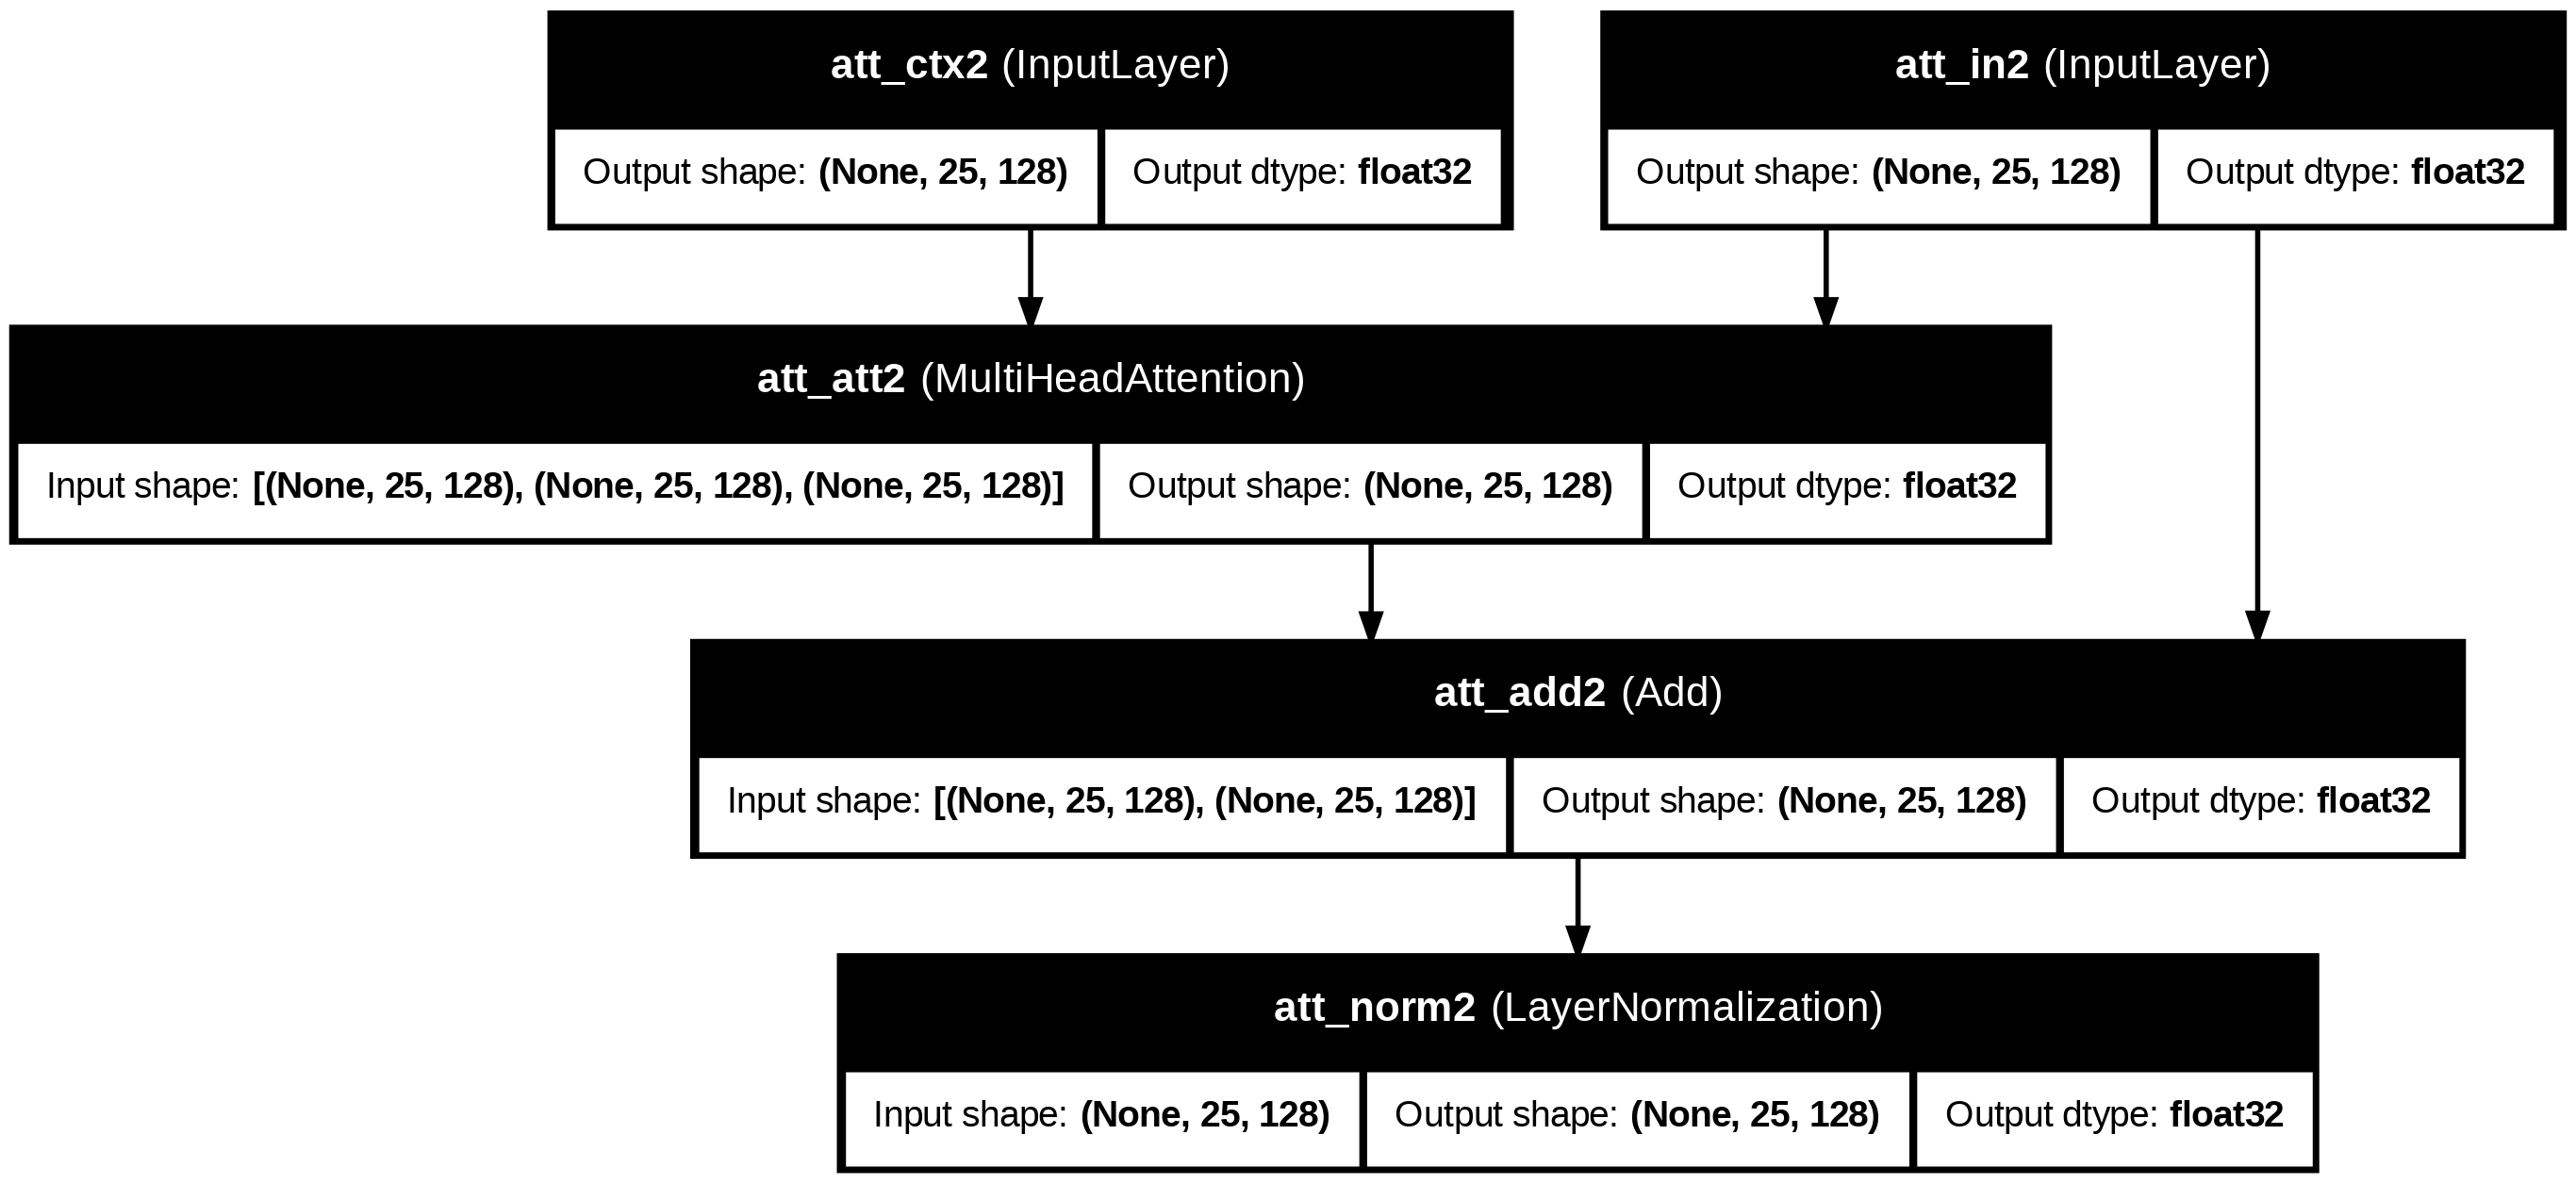

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True,show_layer_names=True,show_layer_activations=True)

In [ ]:
def feed_forward(input_shape,model_dim,ff_dim,dropout=.1,prefix="ff"):
  inputs=tf.keras.layers.Input(shape=input_shape,dtype="float32",name=f"{prefix}_in3")
  dense1=tf.keras.layers.Dense(ff_dim,name=f"{prefix}_ff1",activation="relu")
  dense2=tf.keras.layers.Dense(model_dim,name=f"{prefix}_ff2")
  drop=tf.keras.layers.Dropout(dropout,name=f"{prefix}_drop")
  add=tf.keras.layers.Add(name=f"{prefix}_add3")

  ffout=drop(dense2(dense1(inputs)))
  norm=tf.keras.layers.LayerNormalization(name=f"{prefix}_norm3")
  output=norm(add([inputs,ffout]))
  model=tf.keras.Model(inputs=inputs,outputs=output,name=f"{prefix}_ff")
  return model

In [ ]:
ff_dim=512
model=feed_forward(input_shape=(seq_length,key_dim),model_dim=key_dim,ff_dim=ff_dim)

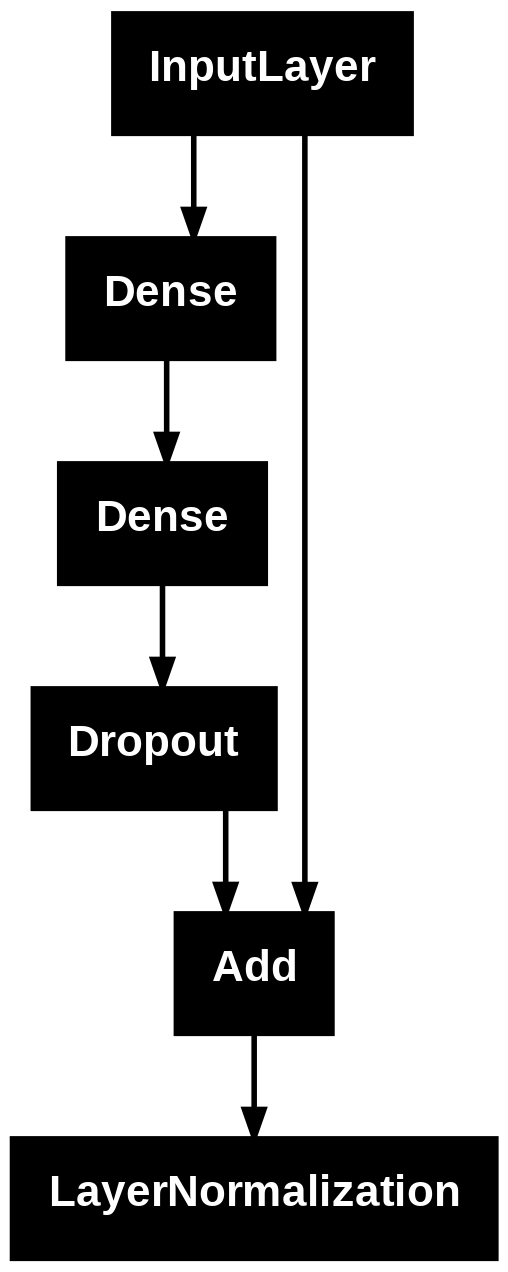

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
import tensorflow as tf
def encoder(input_shape,key_dim,ff_dim,dropout=.1,prfix='enc',**kwargs):
  model=tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=input_shape,dtype='float32',name=f"{prfix}_in0"),
      self_attention(input_shape,prefix=prfix,key_dim=key_dim,mask=False,**kwargs),
      feed_forward(input_shape,key_dim,ff_dim,dropout=dropout,prefix=prfix)
  ])
  return model

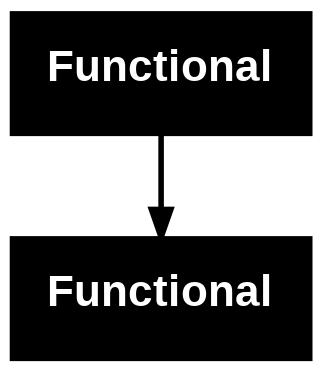

In [ ]:
seq_length=25
key_dim=128
num_heads=8
ff_dim=512
model=encoder(input_shape=(seq_length,key_dim),key_dim=key_dim,ff_dim=ff_dim,num_heads=num_heads)
tf.keras.utils.plot_model(model)

In [ ]:
def decoder(input_shape,key_dim,ff_dim,dropout=.1,prefix="dec",**kwargs):
  input=tf.keras.layers.Input(shape=input_shape,dtype="float32",name=f"{prefix}_in0")
  context=tf.keras.layers.Input(shape=input_shape,dtype="float32",name=f"{prefix}_ctx0")
  attmodel=self_attention(input_shape,prefix=prefix,key_dim=key_dim,mask=True,**kwargs)
  crossmodel=cross_attention(input_shape,input_shape,key_dim=key_dim,prfix=prefix,**kwargs)
  ffmodel=feed_forward(input_shape,key_dim,ff_dim,dropout=dropout,prefix=prefix)
  x=attmodel(input)
  crossout=crossmodel((context,x))
  output=ffmodel(crossout)
  model=tf.keras.Model(inputs=[(context,input)],outputs=output,name=prefix)
  return model

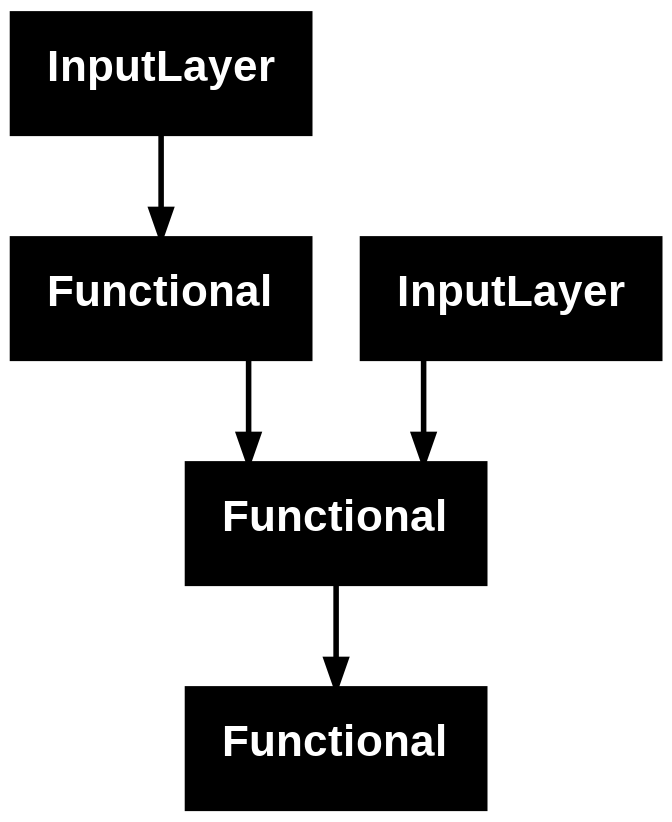

In [ ]:
seq_length=25
key_dim=128
num_heads=8
ff_dim=512
model=decoder(input_shape=(seq_length,key_dim),key_dim=key_dim,ff_dim=ff_dim,num_heads=num_heads)
tf.keras.utils.plot_model(model)

In [ ]:
import tensorflow as tf

def encoder(input_shape,key_dim,ff_dim,dropout=.1,prfix='enc',**kwargs):
  model=tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=input_shape,dtype='float32',name=f"{prfix}_in0"),
      self_attention(input_shape,key_dim=key_dim,mask=False,**kwargs),
      feed_forward(input_shape,key_dim,ff_dim,dropout=dropout,prefix=prfix)
  ])
  return model

def decoder(input_shape,key_dim,ff_dim,dropout=.1,prefix="dec",**kwargs):
  input=tf.keras.layers.Input(shape=input_shape,dtype="float32",name=f"{prefix}_in0")
  context=tf.keras.layers.Input(shape=input_shape,dtype="float32",name=f"{prefix}_ctx0")
  attmodel=self_attention(input_shape,key_dim=key_dim,mask=True,**kwargs)
  crossmodel=cross_attention(input_shape,input_shape,key_dim=key_dim,prfix=prefix,**kwargs)
  ffmodel=feed_forward(input_shape,key_dim,ff_dim,dropout=dropout,prefix=prefix)
  x=attmodel(input)
  crossout=crossmodel((context,x))
  output=ffmodel(crossout)
  model=tf.keras.Model(inputs=[context, input], outputs=output, name=prefix)
  return model

def transformer(num_layers,num_heads,seq_length,key_dim,ff_dim,vocab_size_en,vocab_size_fr,dropout=.1,name="transformer"):
  input_enc=tf.keras.layers.Input(shape=(seq_length,),dtype="float32",name="enc_inp")
  input_dec=tf.keras.layers.Input(shape=(seq_length,),dtype="float32",name="dec_inp") # Modified seq_length for decoder input
  embed_enc=PositionalEmbedding(seq_length,vocab_size_en,key_dim,name="embed_enc")
  embed_dec=PositionalEmbedding(seq_length,vocab_size_fr,key_dim,name="embed_dec") # Modified seq_length for decoder embedding
  encoder_layers=[encoder(input_shape=(seq_length,key_dim),key_dim=key_dim,ff_dim=ff_dim,dropout=dropout,prefix=f"enc{i}",num_heads=num_heads) for i in range (num_layers)]
  decoder_layers=[decoder(input_shape=(seq_length,key_dim),key_dim=key_dim,ff_dim=ff_dim,dropout=dropout,prefix=f"dec{i}",num_heads=num_heads) for i in range (num_layers)] # Modified input_shape for decoder layers
  final=tf.keras.layers.Dense(vocab_size_fr,name="linear")

  x1=embed_enc(input_enc)
  x2=embed_dec(input_dec)
  for layer in encoder_layers:
    x1=layer(x1)
  for layer in decoder_layers:
    x2=layer((x1, x2)) # Corrected input order
  output=final(x2)
  try:
    del output.keras_mask
  except:
    pass
  model=tf.keras.Model(inputs=[input_enc,input_dec],outputs=output,name=name)
  return model

In [ ]:
decoder_input = tf.keras.Input(shape=(seq_length - 1, key_dim))

In [ ]:
# decoder_input_data = decoder_input_data[:, :-1, :]  # Trim to 24

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'dec0' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


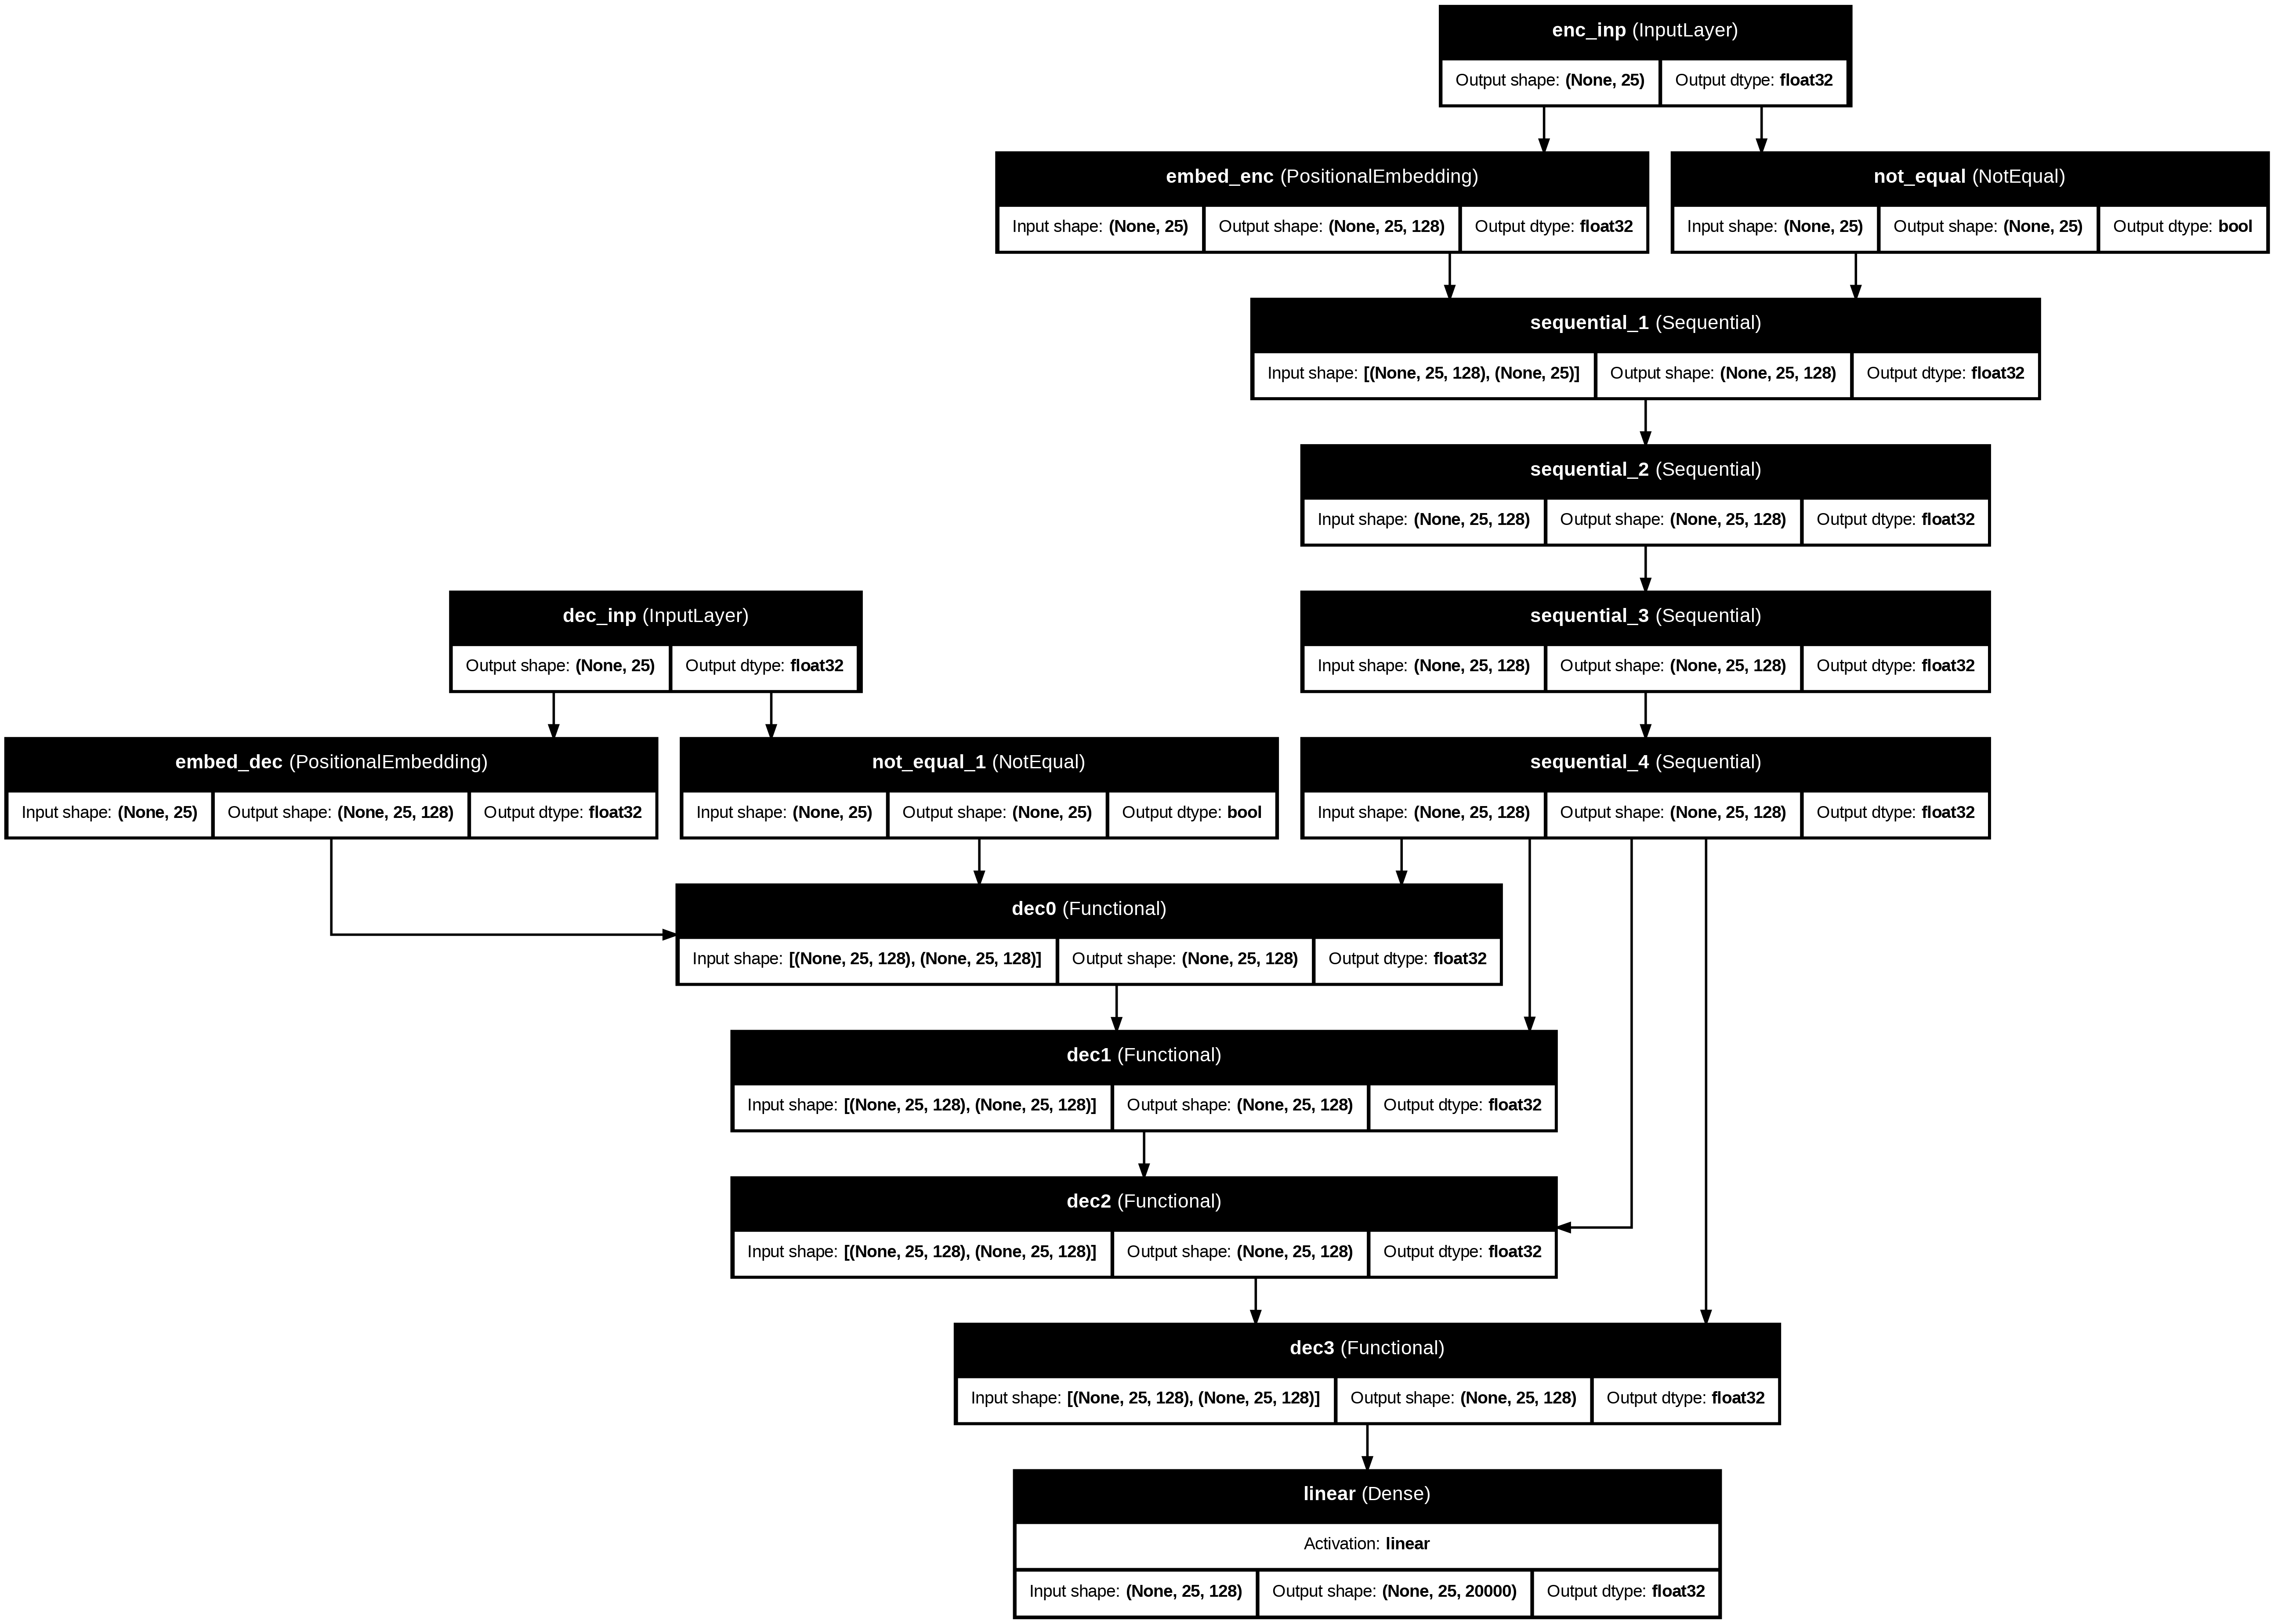

In [ ]:


seq_length=25
num_layers=4
key_dim=128
num_heads=8
ff_dim=512
dropout=.1
vocab_size_en=10000
vocab_size_fr=20000

model=transformer(num_layers,num_heads,seq_length,key_dim,ff_dim,vocab_size_en,vocab_size_fr)
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True,show_layer_names=True,show_layer_activations=True)



In [ ]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
model.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_inp             │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_enc           │ (None, 25, 128)   │  1,280,000 │ enc_inp[0][0]     │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 25)        │          0 │ enc_inp[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 25, 128)   │    659,712 │ embed_enc[0][0],  │
│ (Sequential)        │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 25, 128)   │    659,712 │ sequential_1[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 25, 128)   │    659,712 │ sequential_2[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_inp             │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 25, 128)   │    659,712 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_dec           │ (None, 25, 128)   │  2,560,000 │ dec_inp[0][0]     │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 25)        │          0 │ dec_inp[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec0 (Functional)   │ (None, 25, 128)   │  1,187,456 │ sequential_4[0][… │
│                     │                   │            │ embed_dec[0][0],  │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec1 (Functional)   │ (None, 25, 128)   │  1,187,456 │ sequential_4[0][… │
│                     │                   │            │ dec0[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec2 (Functional)   │ (None, 25, 128)   │  1,187,456 │ sequential_4[0][… │
│                     │                   │            │ dec1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec3 (Functional)   │ (None, 25, 128)   │  1,187,456 │ sequential_4[0][… │
│                     │                   │            │ dec2[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ linear (Dense)      │ (None, 25, 20000) │  2,580,000 │ dec3[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,808,672 (52.68 MB)

 Trainable params: 13,808,672 (52.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history=model.fit(train_ds,epochs=20,validation_data=test_ds)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'sequential_1' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'att_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-

1563/1828 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.1454 - loss: 6.2687

In [ ]:
class customSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self,key_dim,warmup_steps=40000):
    super().__init__()
    self.key_dim=key_dim
    self.warmup_steps=warmup_steps
    self.d=tf.cast(self.key_dim,tf.float32)

  def __call__(self,step):
    step=tf.cast(step,tf.float32)
    arg1=tf.math.rsqrt(step)
    arg2=step*(self.warmup_steps**-1.5)
    return tf.math.rsqrt(self.d)*tf.math.minimum(arg1,arg2)

  def get_config(self):
    config={"key_dim":self.key_dim,"warmup_steps":self.warmup_steps}
    return config

key_dim=128
lr=customSchedule(key_dim)
optimizer=tf.keras.optimizers.Adam(lr,beta_1=0.9,beta_2=0.98,epsilon=1e-9)

In [ ]:
def masked_loss(label,pred):
  mask=label!=0
  loss_object=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction="none")
  loss=loss_object(label,pred)

  mask=tf.cast(mask,dtype=loss.dtype)
  loss*=mask
  loss=tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label,pred):
  pred=tf.argmax(pred,axis=2)
  label=tf.cast(label,pred.dtype)
  match=label==pred

  mask=label!=0
  match=match & mask

  match=tf.cast(match,dtype=tf.float32)
  mask=tf.cast(mask,dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model.compile(loss=masked_loss,optimizer=optimizer,metrics=[masked_accuracy])
model.summary()

In [ ]:
import matplotlib.pyplot as plt
fig,axes=plt.subplots(2,1,figsize=(6,8),sharex=True)
fig.suptitle("training history")
x=list(range(1,21))
axes[0].plot(x,history.history["loss"],alpha=.5,label="train")
axes[0].plot(x,history.history["val_loss"],alpha=.5,label="val")
axes[0].set_ylabel("loss")
axes[0].legend()
axes[1].plot(x,history.history["masked_accuracy"],alpha=.5,label="masked_accuracy")
axes[1].plot(x,history.history["val_masked_accuracy"],alpha=.5,label="val_masked_accuracy")
axes[1].set_ylabel("accuracy")
axes[1].set_xlabel("epoch")
axes[1].legend(loc="lower right")
plt.show()

In [ ]:
def translate(sentence):
    enc_tokens = eng_vect([sentence])
    lookup = list(fre_vect.get_vocabulary())
    start_sent, end_sent = "[start]", "[end]"
    output_sent = [start_sent]

    for i in range(seq_len):  # assuming seq_len is globally defined
        vector = fre_vect([' '.join(output_sent)])
        assert vector.shape == (1, seq_len), f"Unexpected shape for decoder input: {vector.shape}"

        dec_tokens = vector
        pred = model([enc_tokens, dec_tokens])  # correct structure
        assert pred.shape == (1, seq_len, vocab_fr), f"Unexpected prediction shape: {pred.shape}"

        word = lookup[np.argmax(pred[0, i, :])]
        if word == end_sent:
            break
        output_sent.append(word)

    return output_sent[1:]  # Skip [start] token in final output


In [ ]:
seq_length=25
vocab_size_en=10000
vocab_size_fr=20000
test_count=20
for n in range(test_count):
  eng_sent,fre_sent=random.choice(test_pair)
  trans=translate(eng_sent)

  print(f"Test case:{n}")
  print(f"English sentance:{eng_sent}")
  print(f"French sentance:{fre_sent}")
  print(f"Predicted sentance:{' '.join(trans)}")

In [ ]:
model.save()